In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.imputation.mice as smi
import copy
import datetime


Head(10)
              date_time    BANC     CISO    LDWP   TIDC
0  2015-07-01T05:00:00Z     NaN      NaN     NaN    NaN
1  2015-07-01T06:00:00Z     NaN      NaN     NaN    NaN
2  2015-07-01T07:00:00Z     NaN      NaN     NaN    NaN
3  2015-07-01T08:00:00Z     NaN      NaN     NaN    NaN
4  2015-07-01T09:00:00Z  2275.0  28989.0  3045.0  380.0
5  2015-07-01T10:00:00Z  2104.0  27416.0  2892.0  357.0
6  2015-07-01T11:00:00Z  1988.0  26388.0  2787.0  342.0
7  2015-07-01T12:00:00Z  1958.0  25661.0  2790.0    NaN
8  2015-07-01T13:00:00Z  2006.0  25845.0  2899.0  347.0
9  2015-07-01T14:00:00Z  2076.0  26555.0  3097.0  356.0

Describe
           BANC      CISO      LDWP      TIDC
count  33909.00  34530.00  34175.00  30772.00
mean    1998.16  25947.59   3244.03    298.94
std      512.90   5066.33    752.67     77.42
min     1260.00  14663.00   2019.00    184.00
25%     1675.00  22253.00   2699.00    248.00
50%     1885.00  25154.00   3127.00    279.00
75%     2111.00  28070.75   3532.00    320

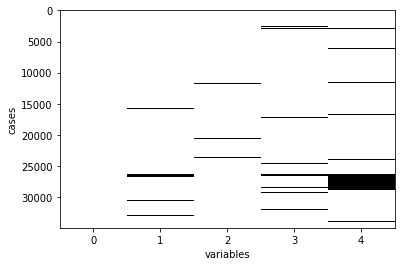

In [2]:
# Load with various verbose summaries
def load_csv(file_path, columns, na_vals=['NA',], parse_d=True, verbose=0):
    dtype_map = {}
    for col in columns:
        dtype_map[col] = np.float64
    df = pd.read_csv(file_path,
                    dtype=dtype_map,
                    parse_dates=parse_d,
                    na_values=na_vals)
    if verbose >= 1:
        print("\nHead(10)")
        print(df.head(10))
        print("\nDescribe")
        print(df.describe().round(2))
        print("\ndf.isna().sum(axis=0)")
        print(df.isna().sum(axis=0))
    if verbose >= 2:
        plt.imshow(~df.isna(), aspect='auto')
        plt.xlabel("variables")
        plt.ylabel("cases")
        plt.gray()
        plt.show()
    return df


def add_lags(df, regions):
    for r in regions:
        print("Adding lag for region {}".format(r))
        kwargs = {
                 '{}_Lag1'.format(r) : lambda x: np.roll(df[r], +1),
             }
        df = df.assign(**kwargs)
    return df


def drop_col(df, col):
    return df.drop(col, axis=1)


# Impute and save the imputed datasets
# Not sure what the burn in is for these
def impute_MICEData(df, regions, n_iters):
    imp = smi.MICEData(df)
    regs = list(regions)
    r_main = regs.pop()
    regs2 = []
    for r in regs:
        regs2.append(r)
        regs2.append(r+'_Lag1')
    regs2.append(r_main+'_Lag1')
    f = ' + '.join(regs2)
    imp.set_imputer(r_main, formula=f)
    for j in range(n_iters):
        print("MICE imputation {}".format(j))
        imp.update_all()
        imp.data.to_csv('data%02d.csv' % j, index=False)

file_path = 'pre_imputed_CA_data.csv'
regions = ['BANC', 'CISO', 'LDWP', 'TIDC']
df = load_csv(file_path, regions, ['NA',], True, 2)
#df = add_lags(df, regions)
#df = drop_col(df, 'date_time')
#impute_MICEData(df, regions, 5)

BANC
Length simp_res 1004.0


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  


Length simp_res 1004.0
Length simp_res 353.0
Length simp_res 353.0
Length simp_res 651.0
Length simp_res 651.0
CISO
Length simp_res 383.0
Length simp_res 383.0
Length simp_res 97.0
Length simp_res 97.0
Length simp_res 286.0
Length simp_res 286.0
LDWP
Length simp_res 738.0
Length simp_res 738.0
Length simp_res 167.0
Length simp_res 167.0
Length simp_res 571.0
Length simp_res 571.0
TIDC
Length simp_res 4108.0
Length simp_res 4108.0


/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Length simp_res 1354.0
Length simp_res 1354.0
Length simp_res 2754.0
Length simp_res 2754.0


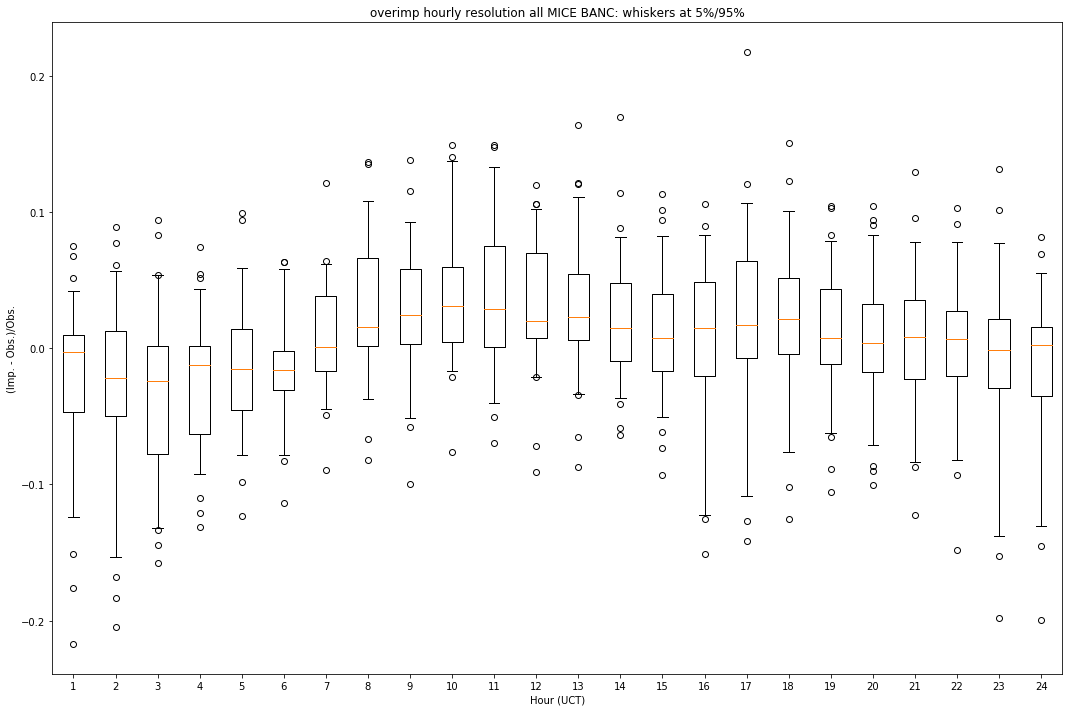

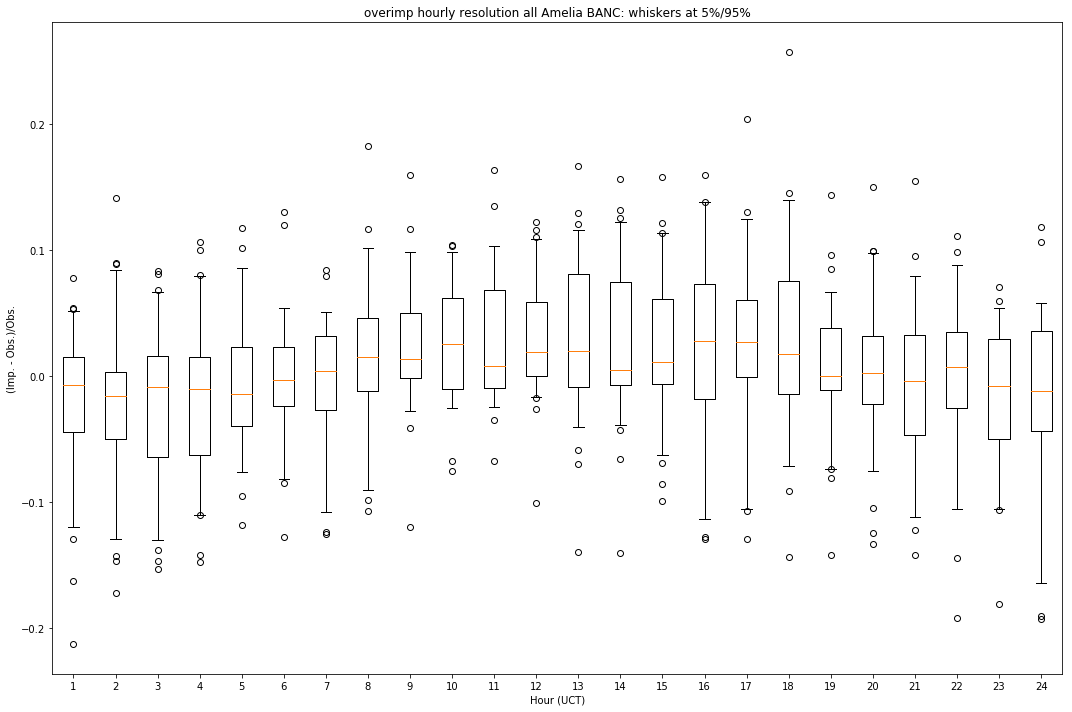

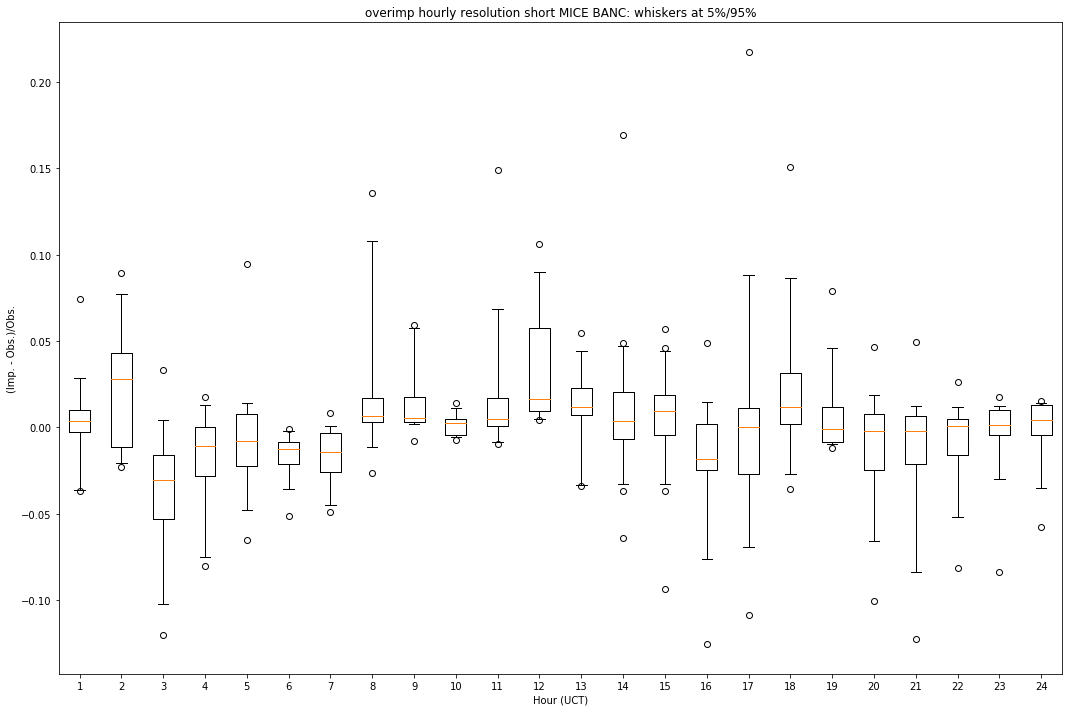

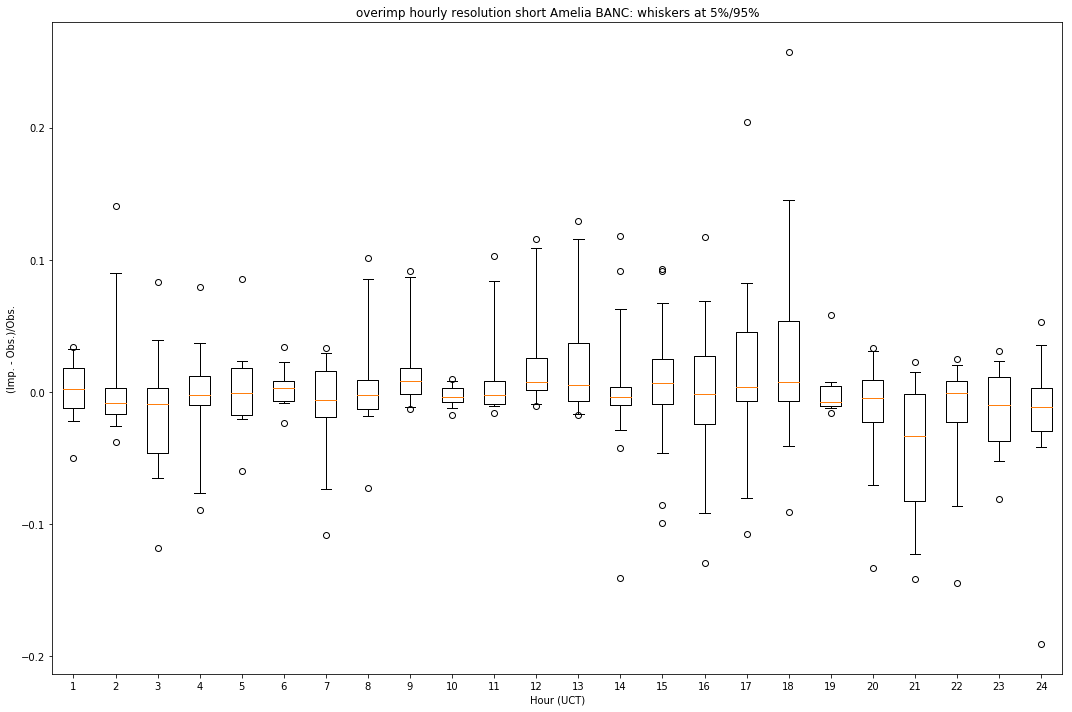

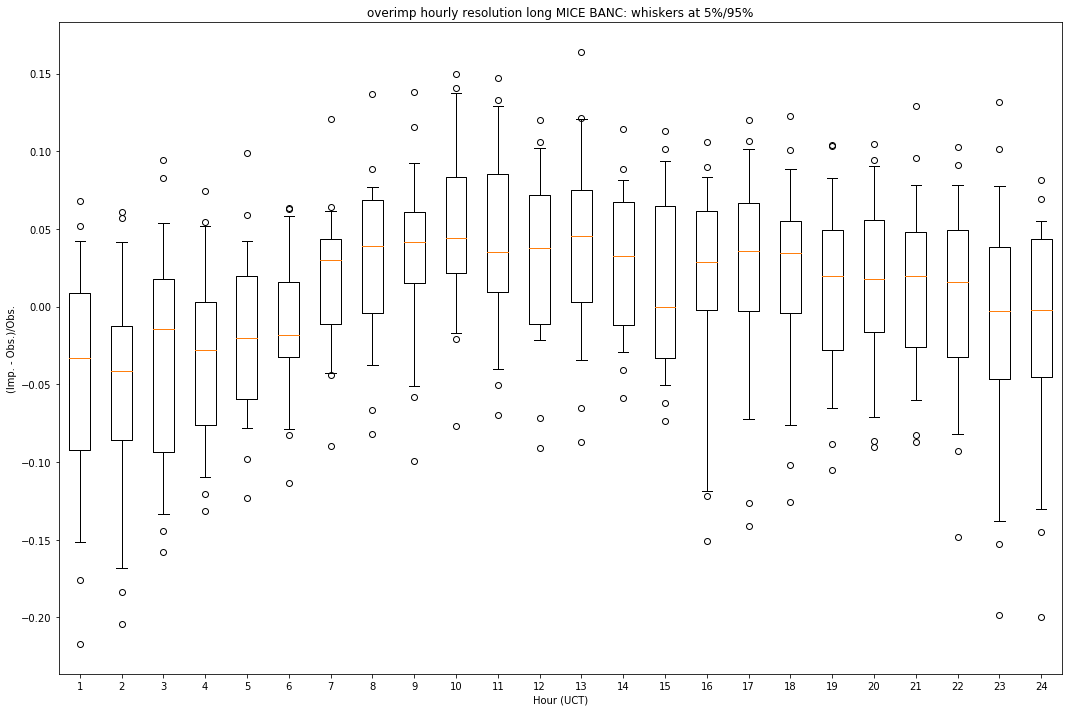

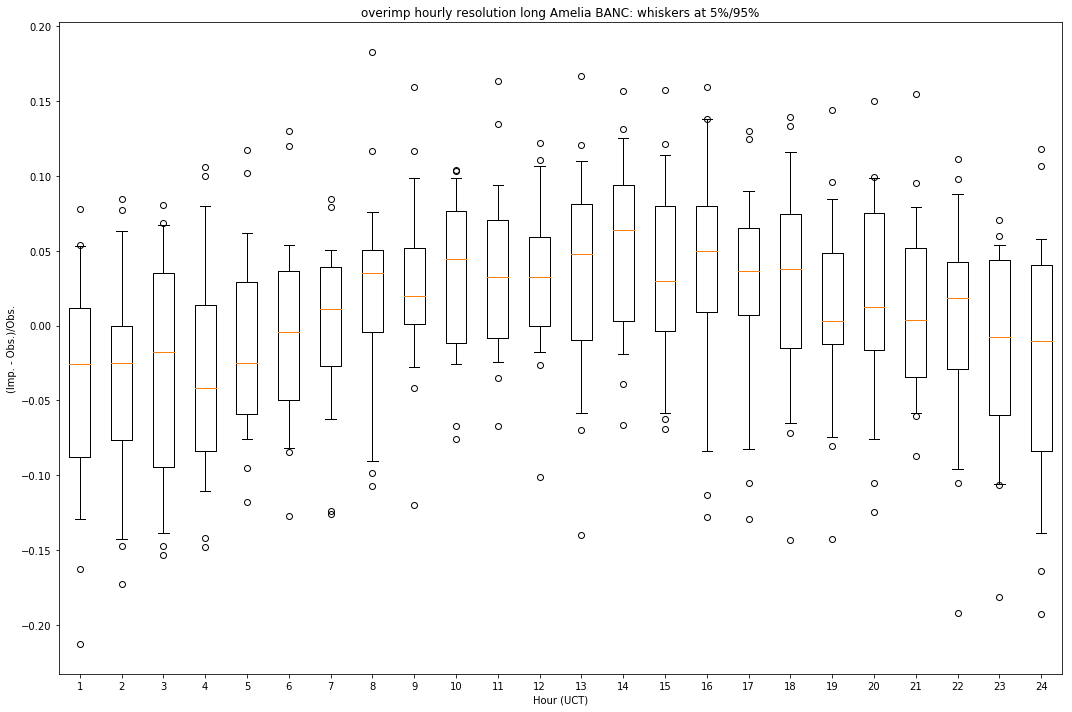

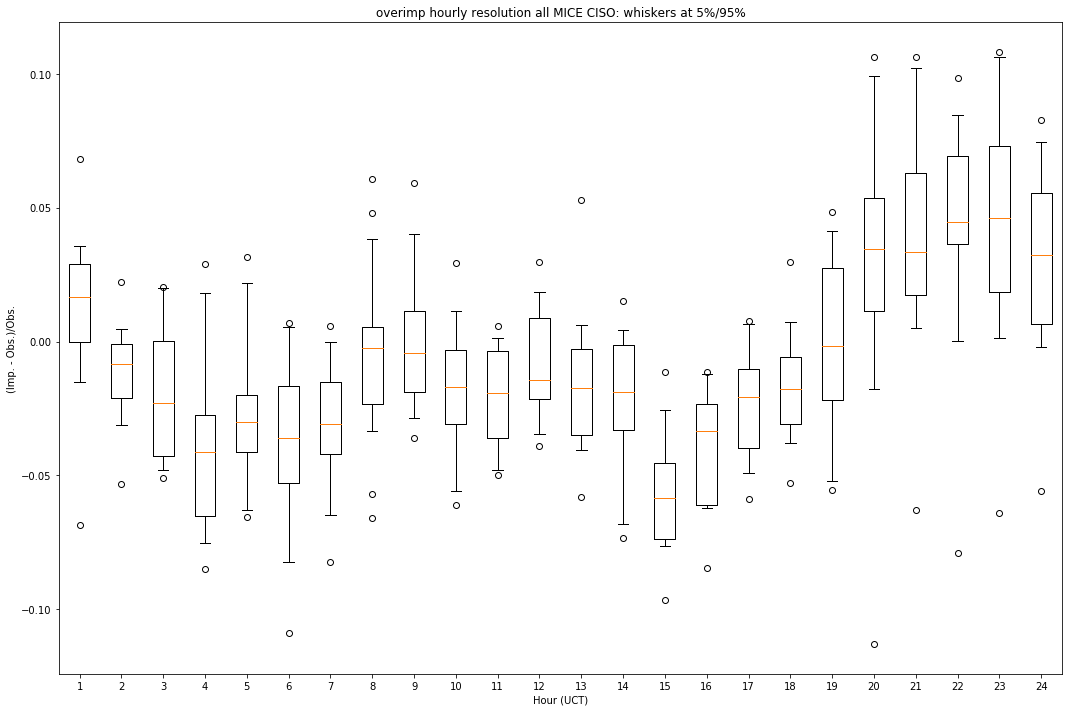

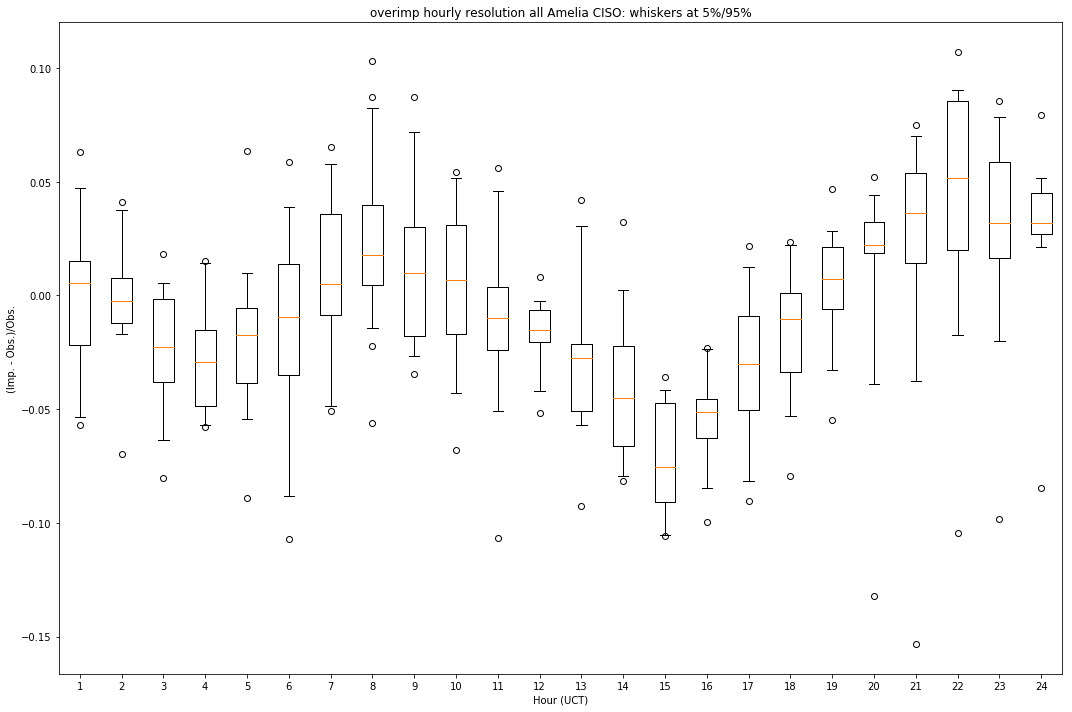

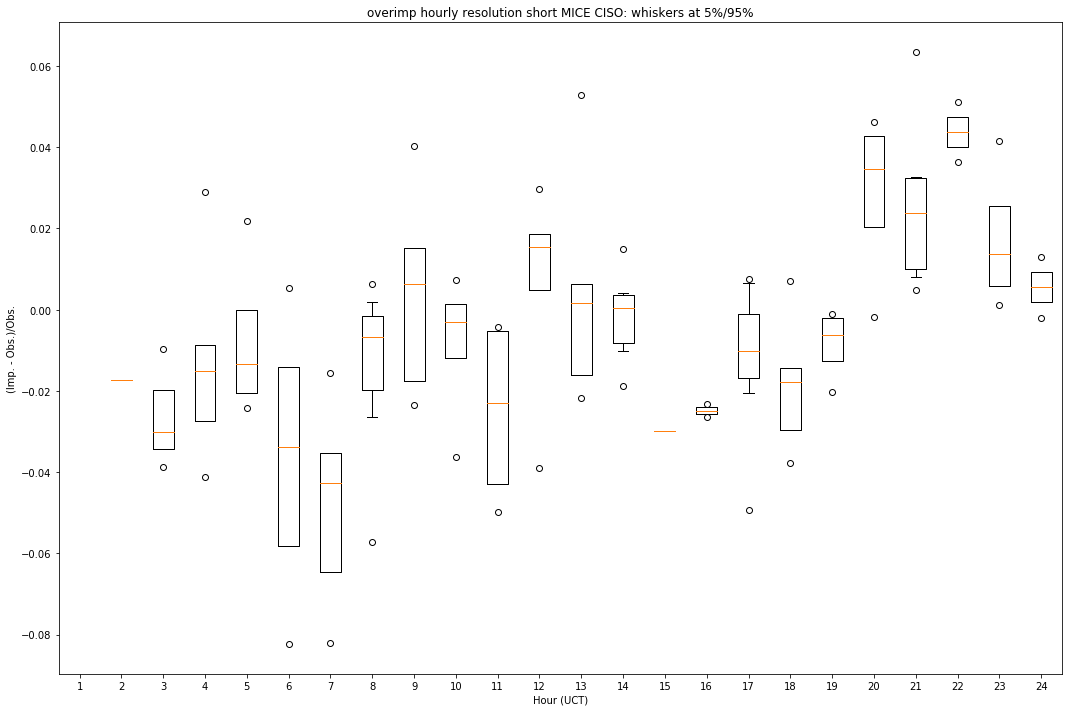

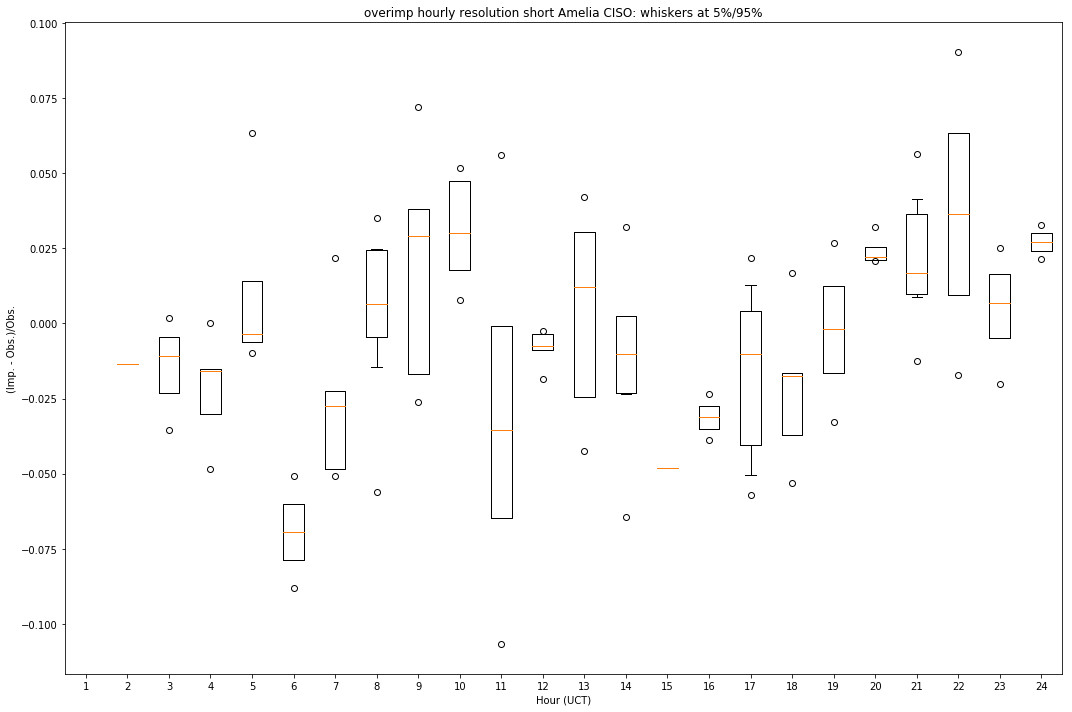

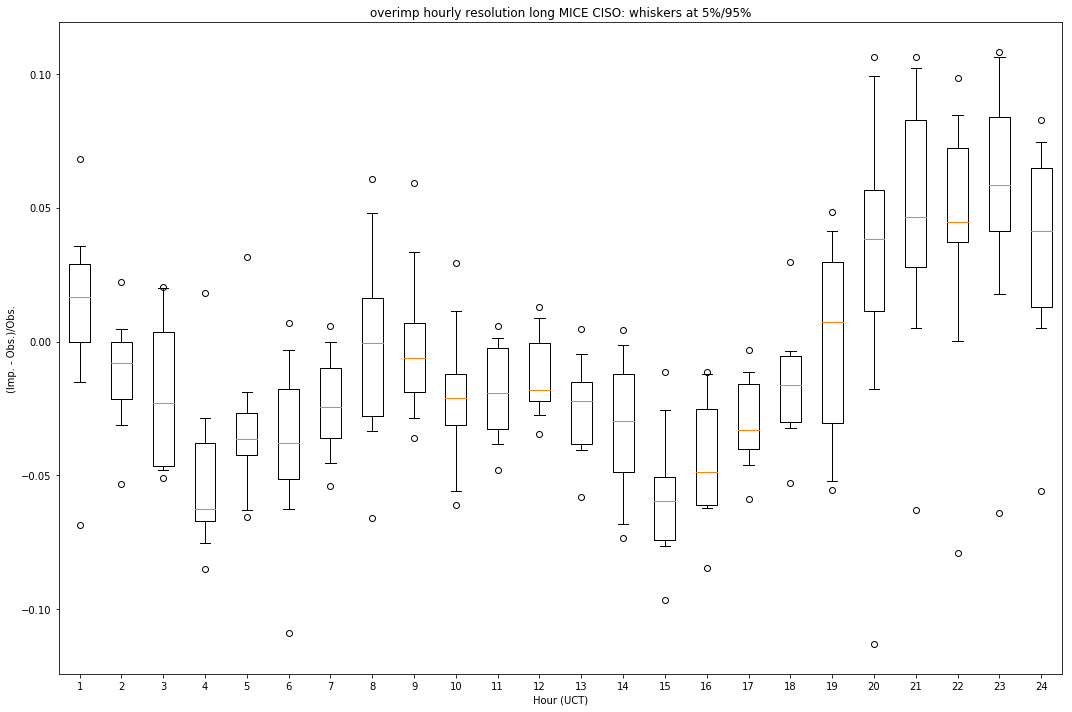

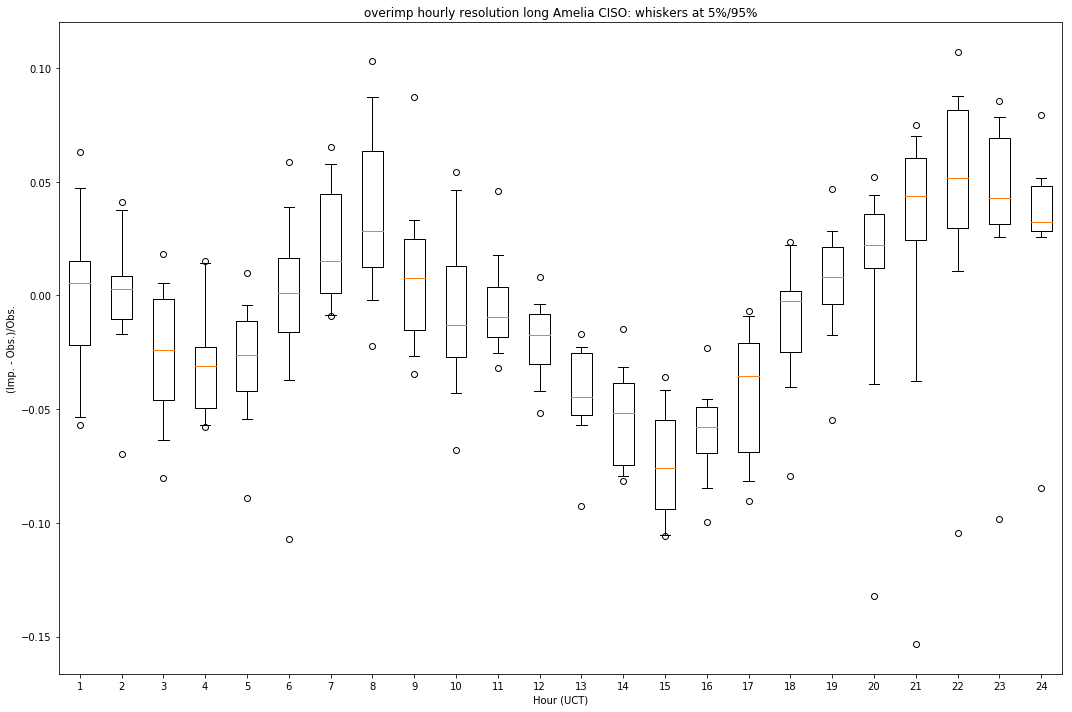

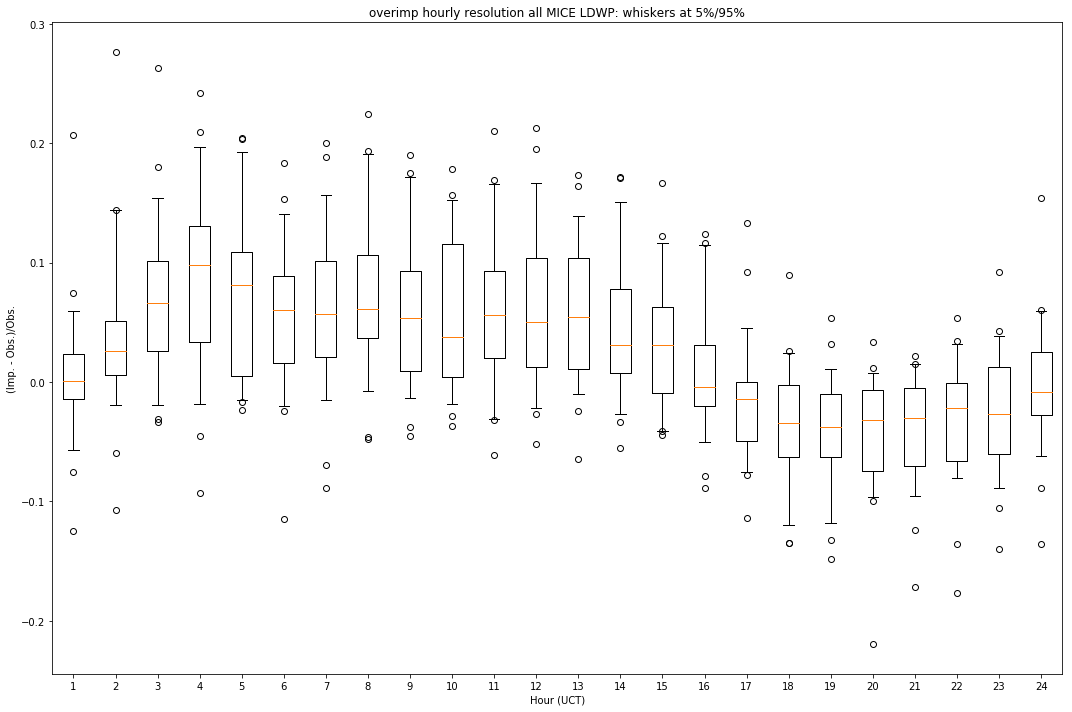

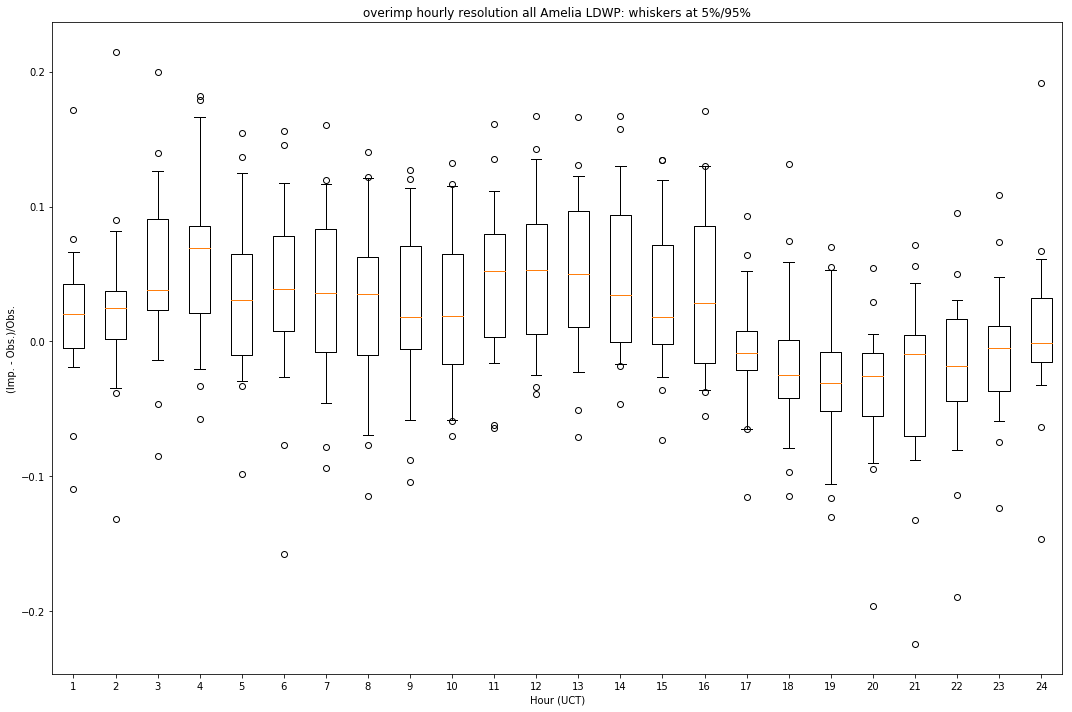

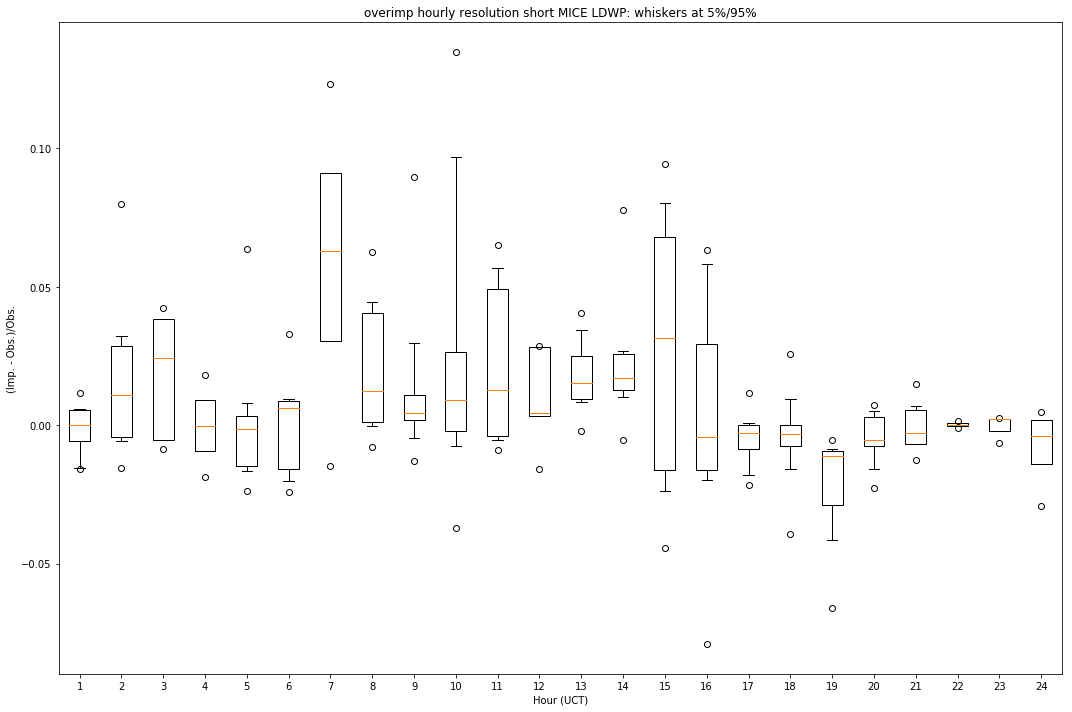

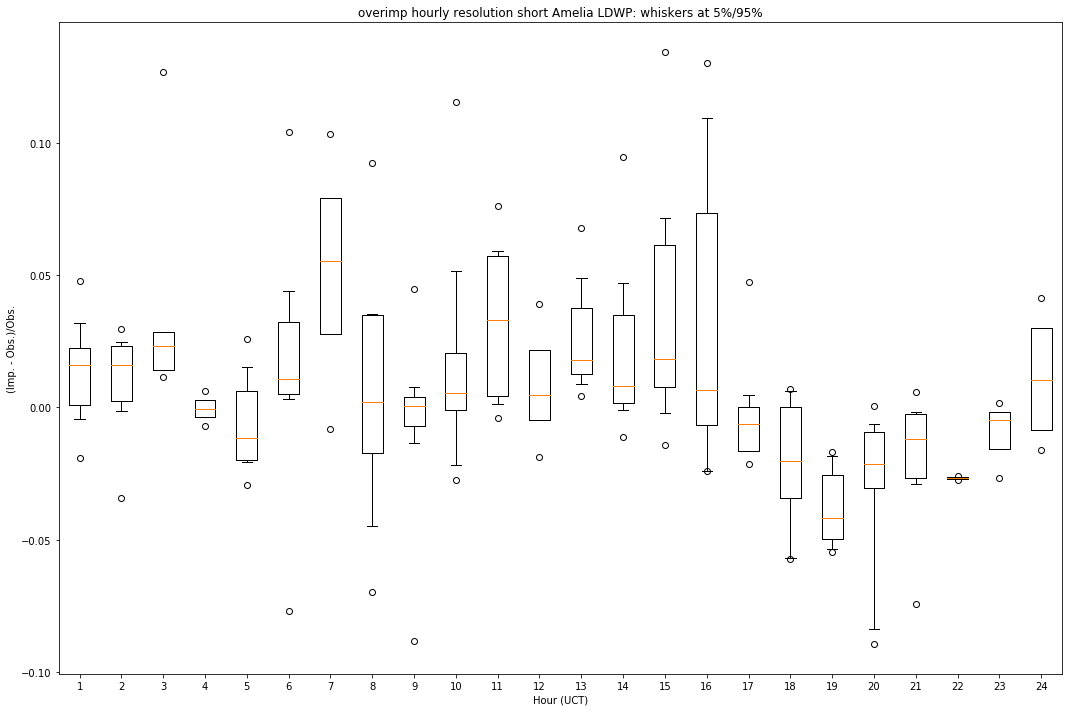

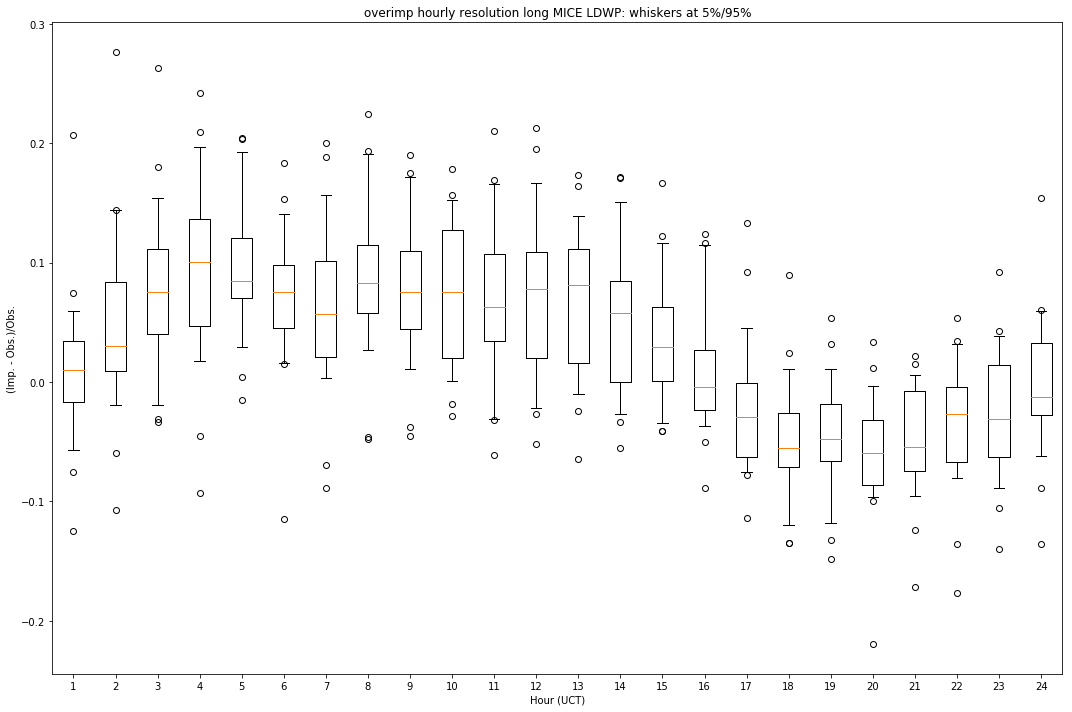

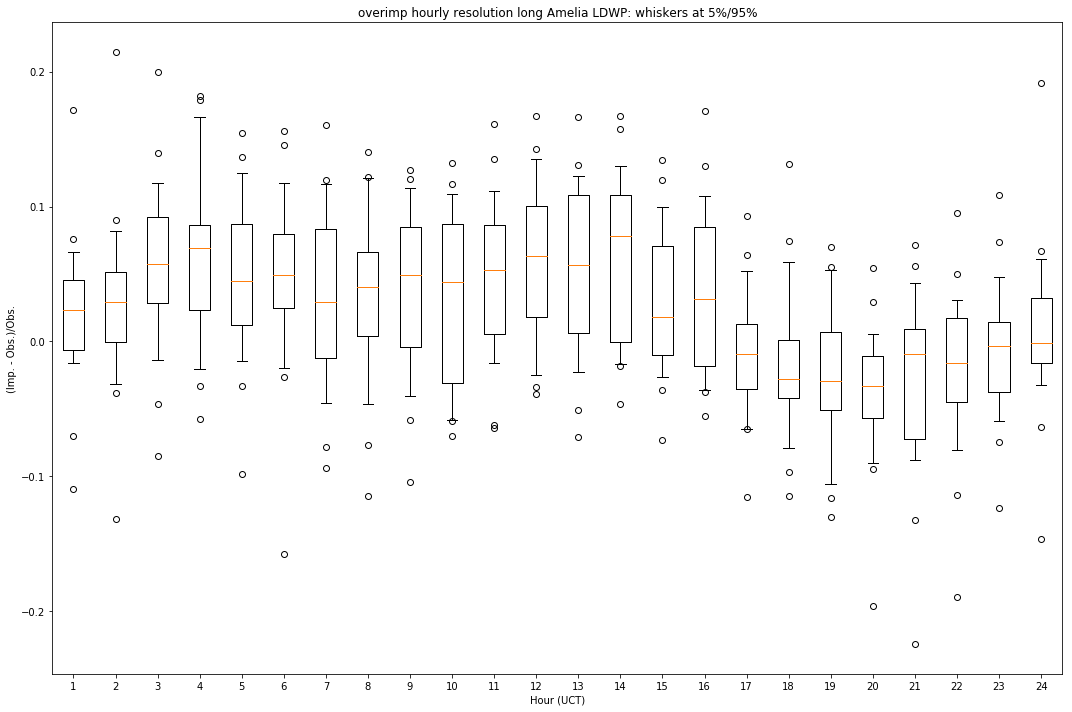

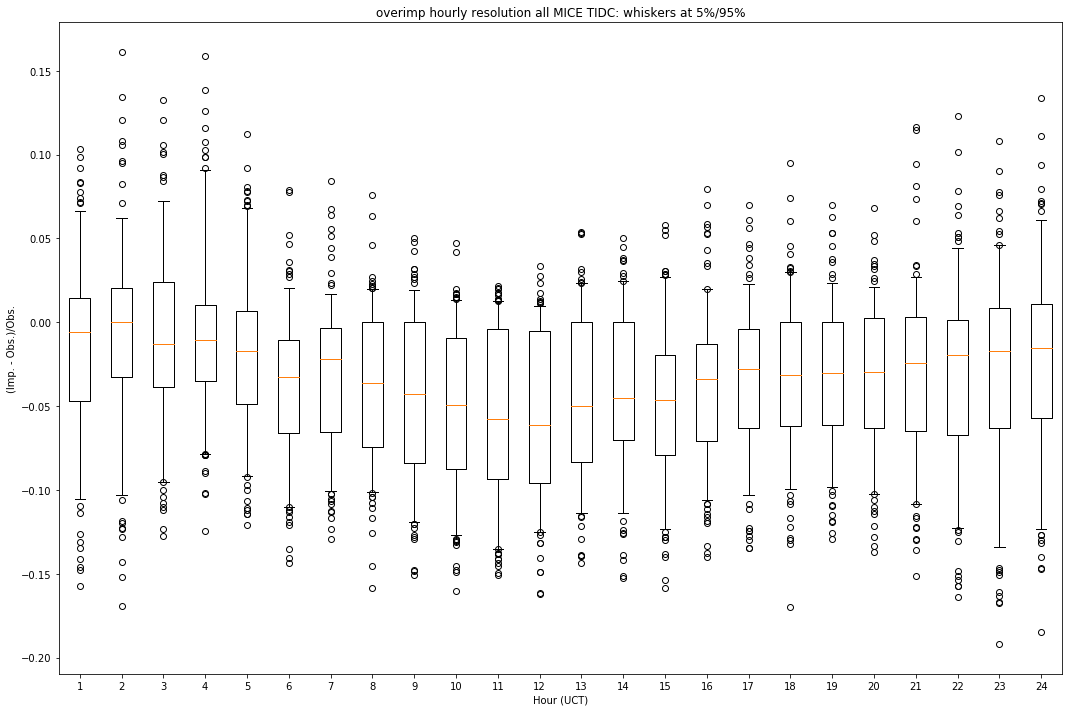

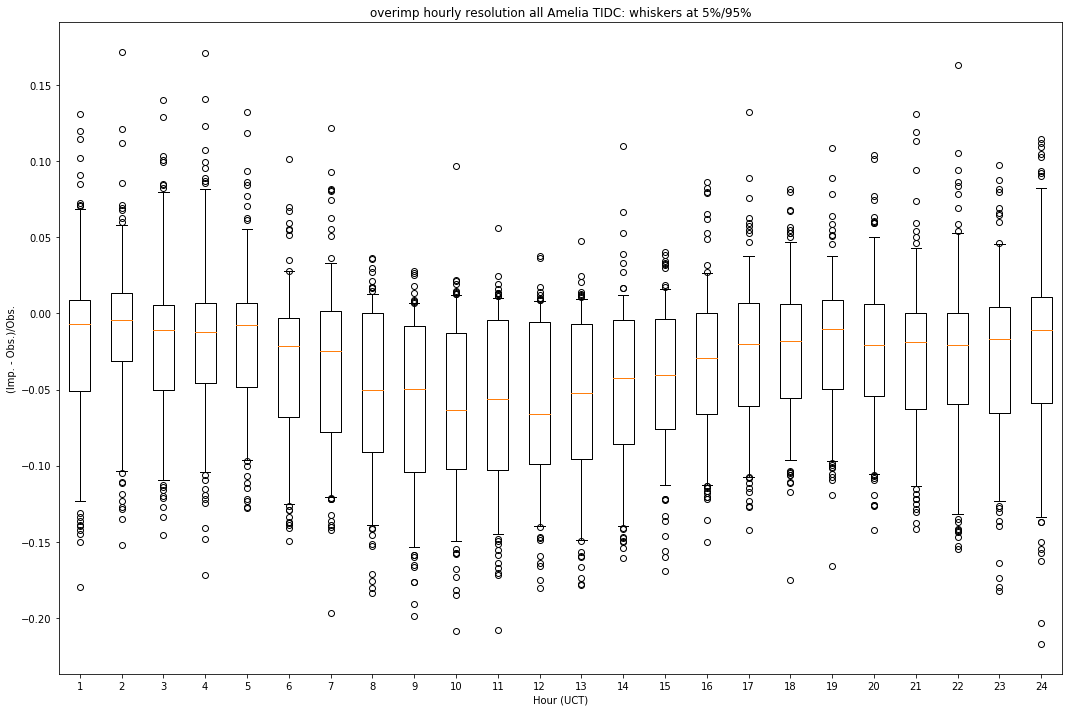

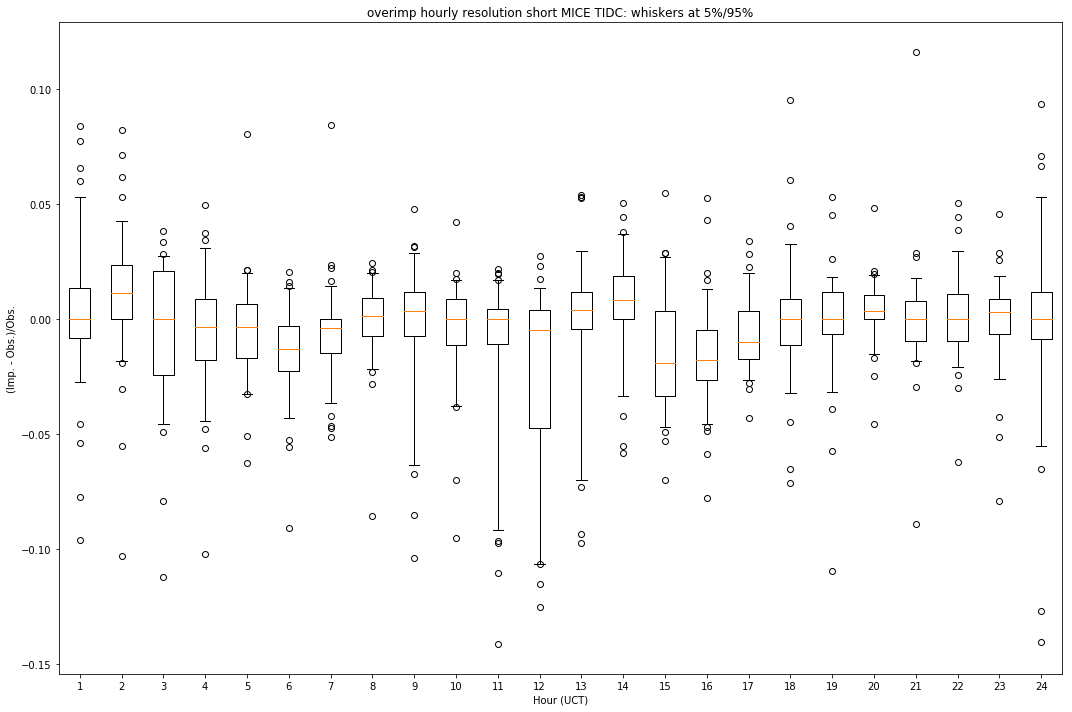

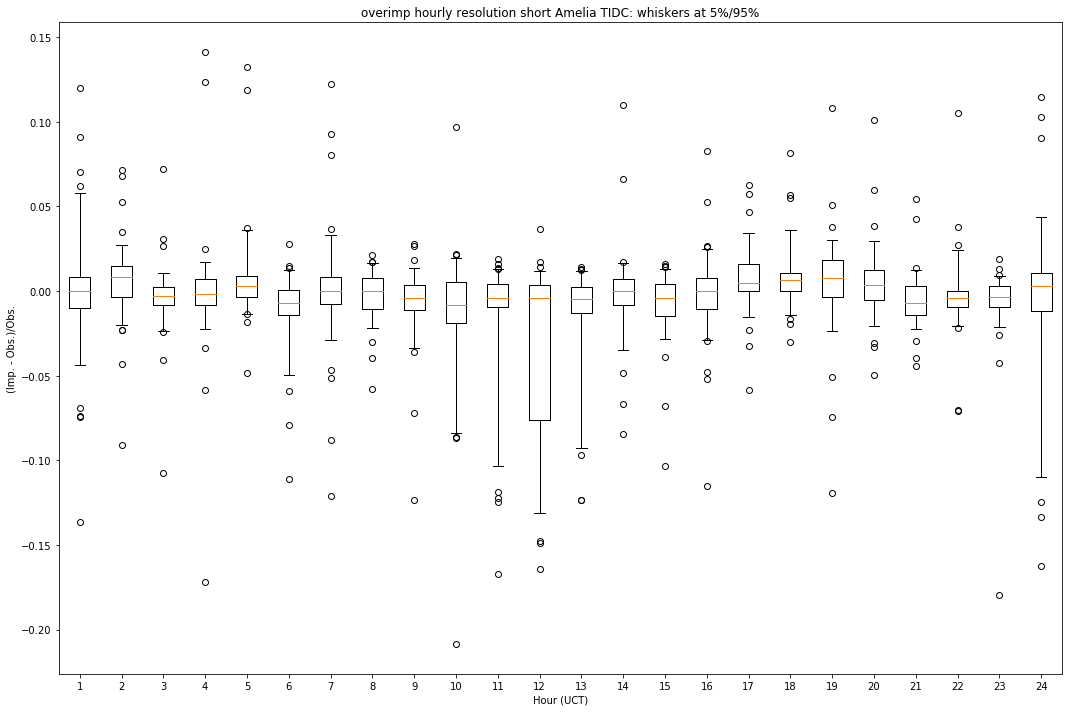

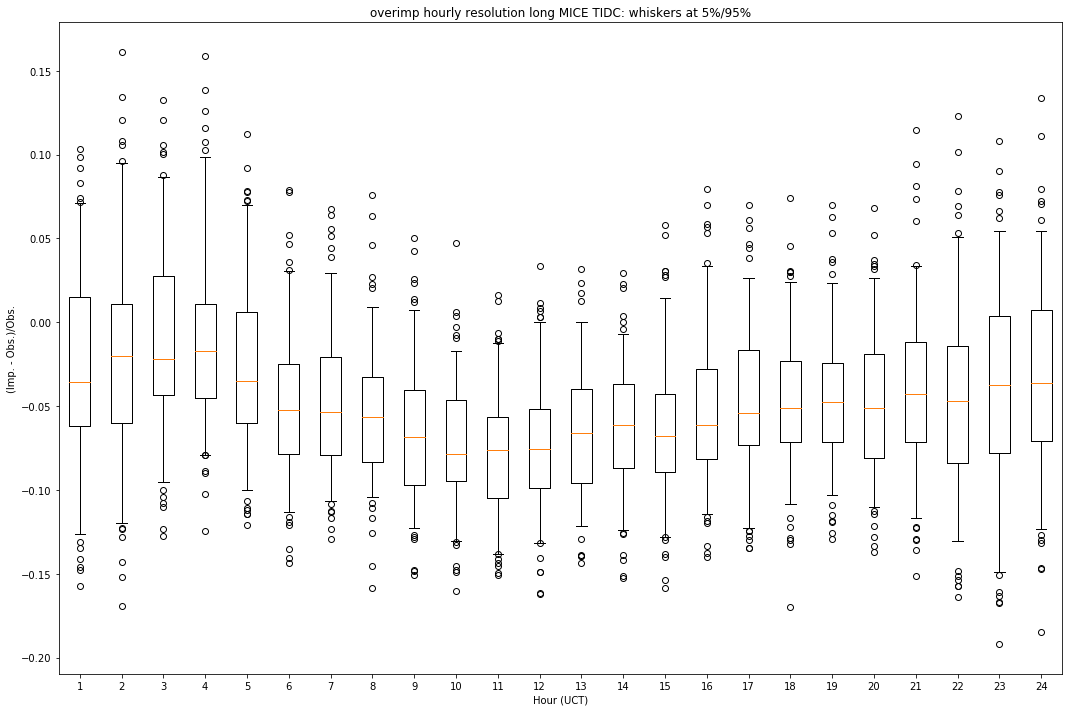

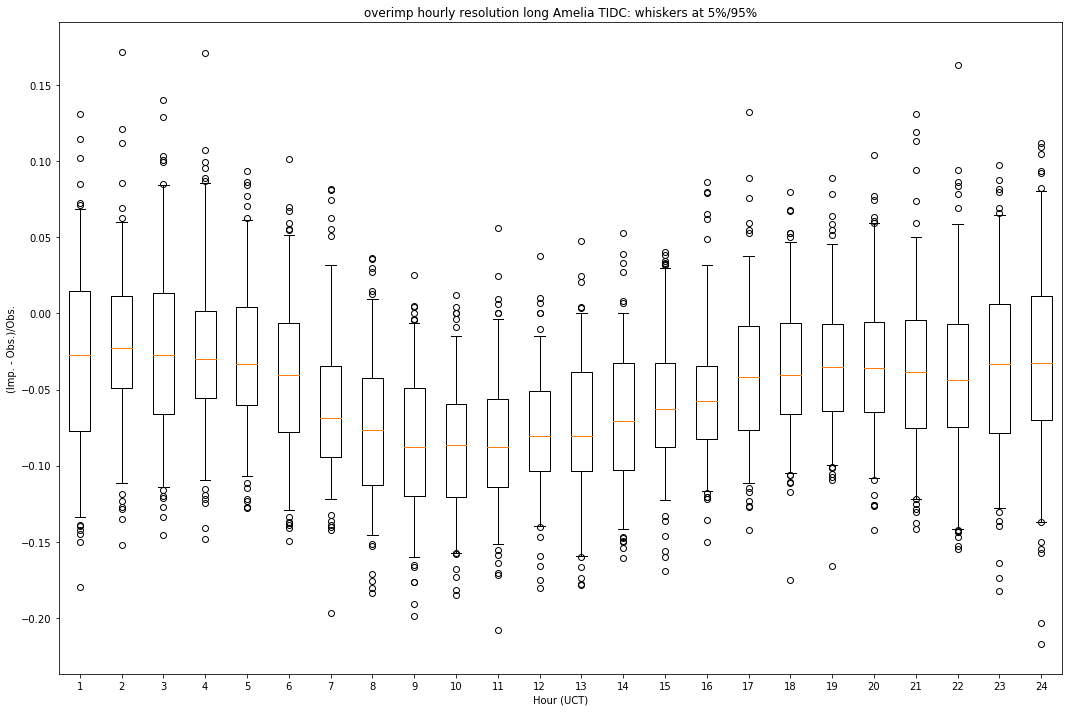

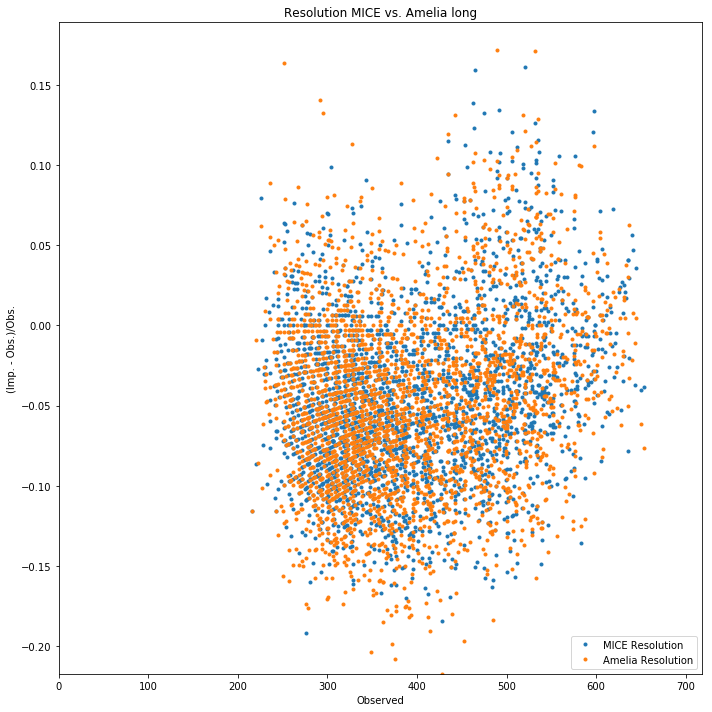

In [3]:
def return_imputed_indices(raw, name):
    index = pd.isnull(raw[name]).nonzero()[0]
    return index

def get_overimpute_index(raw, imp, col):
    init_nan = return_imputed_indices(raw, col)
    init_nan_set = set()
    for i in init_nan:
        init_nan_set.add(i)
    
    over_nan = return_imputed_indices(imp, col)
    over_nan_set = set()
    for i in over_nan:
        over_nan_set.add(i)
    
    return np.array(list(over_nan_set.difference(init_nan_set)))

def split_index_into_sort_and_long_gaps(index):
    short = []
    long = []
    index.sort()
    prev_was_short = False
    for i in range(len(index)-2): # Can't compare the last one like this
        if index[i+1] == index[i] + 1 and index[i+2] == index[i] + 2:
            long.append(index[i])
            prev_was_short = False
        else:
            short.append(index[i])
            prev_was_short = True
    if prev_was_short:
        short.append(index[-2])
        short.append(index[-1])
    else:
        long.append(index[-2])
        long.append(index[-1])
    return short, long
            
    

    
def return_values_by_index(imp, indices, name, replace_nan_with_zero=True):
    vals = imp.loc[indices, name]
    if replace_nan_with_zero:
        vals = vals.fillna(0)
    return vals

def comparison_demand_plot(original, imp, imp_names, title, save):
    
    plt.close()
    fig, ax = plt.subplots(figsize=(15,5))
    ax.set_xlabel('Hour')
    ax.set_ylabel('Demand')
    plt.title(title)
    ax.plot(original['CISO'], '-', label='CISO Raw')
    for v, name in zip(imp, imp_names):
        ax.plot(v, 'o', label=name)
    plt.legend()
    plt.tight_layout()
    plt.savefig(save)


# Create many demand plots so we can actually see the values
def scrolling_demand(width, original, imp, imp_names, title, save):
    start = 0
    end = width
    i = 0
    tot_l = len(original.index)
    while True:
        s = save.replace('.png', '_{}cnt'.format(i))
        t = title+': cnt {}'.format(i)
        o = original.loc[start:end]
        imps = []
        empty = True
        for im in imp:
            imps.append(im.loc[start:end])
            if len(imps[-1].index) > 0:
                empty = False
        if not empty:
            comparison_demand_plot(o, imps, imp_names, t, s)
        if end == tot_l:
            break
        i += 1
        start += width
        end += width
        if end >= tot_l:
            end = tot_l


def comparison_scatter_plot(v1s, v2s, labels, t1, t2, title, save, float_y_min=False):

    plt.close()
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xlabel(t1)
    ax.set_ylabel(t2)
    max_v1s = np.max( list(map(lambda x: np.max(x), v1s)))
    max_v2s = np.max( list(map(lambda x: np.max(x), v2s)))
    ax.set_xlim(0, max_v1s*1.1)
    min_v2s = 0
    if float_y_min:
        min_v2s = np.min( list(map(lambda x: np.min(x), v2s)))
    ax.set_ylim(min_v2s, max_v2s*1.1)
    plt.title(title)
    for v1, v2, l in zip(v1s, v2s, labels):
        ax.plot(v1, v2, '.', label=l)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig(save)


def simple_resolution(df_true, df_imp, title, save, n_bins=20):

    plt.close()
    if df_true.index.all() != df_imp.index.all():
        print("Indices do not align, exiting simple_resolution")
        return 0

    res_grid = []
    for index, value in df_true.items():
        if value > 0:
            res_grid.append( (df_imp.at[index]-value) / value)
        else:
            print("Value == 0 for simple_resolution {} {}".format(title, save))
    
    fig, ax = plt.subplots(figsize=(10,10))
    n, bins, patches = ax.hist(res_grid, n_bins, 
            facecolor='b', alpha=0.5, density=False)
    print("Length simp_res {}".format(np.sum(n)))
    fig.set_figheight(10)
    fig.set_figwidth(10)
    plt.title(title)
    plt.xlabel('(Imp. - Obs.)/Obs.')
    plt.ylabel('Counts')
    plt.tight_layout()
    plt.savefig(save)


# df_master is used to get the correct UCT time
def resolution_by_time(df_master, df_true, df_imp, title, save):

    plt.close()
    if df_true.index.all() != df_imp.index.all():
        print("Indices do not align, exiting resolution_by_time")
        return 0
    
    # Get UCT time by index
    zero_index_hour = datetime.datetime.strptime(df_master.at[0, 'date_time'], "%Y-%m-%dT%H:%M:%SZ").hour
    
    res_grid = []
    for i in range(24):
        res_grid.append([])
    month_grid = []
    for i in range(12):
        month_grid.append([])
    
    for index, value in df_true.items(): 
        mod = (index + zero_index_hour)%24
        res = (df_imp.at[index]-value) / value
        res_grid[mod].append(res)
        # Get month
        month = datetime.datetime.strptime(df_master.at[index, 'date_time'], "%Y-%m-%dT%H:%M:%SZ").month
        month_grid[month-1].append(res)

    # Plot hourly
    fig, ax = plt.subplots(figsize=(15,10))
    ax.set_title(title+': whiskers at 5%/95%')
    ax.boxplot(res_grid, whis=[5, 95])
    ax.set_xlabel('Hour (UCT)')
    ax.set_ylabel('(Imp. - Obs.)/Obs.')
    plt.tight_layout()
    plt.savefig(save)
    
    # Plot monthly
    fig, ax = plt.subplots(figsize=(15,10))
    ax.set_title(title.replace('hour', 'month')+': whiskers at 5%/95%')
    ax.boxplot(month_grid, whis=[5, 95])
    ax.set_xlabel('Month')
    ax.set_ylabel('(Imp. - Obs.)/Obs.')
    plt.tight_layout()
    plt.savefig(save.replace('hour', 'month'))

    

## Open a saved csv and check contents
base = '/Users/truggles/Downloads/'
df_mice = load_csv(base+'mean_impute_CA_overimpute3_mice (2).csv', 
                   regions, ['NA',], True, 0)
df_amelia = load_csv(base+'mean_impute_CA_overimpute3_amelia (2).csv', 
                   regions, ['NA',], True, 0)
imp = load_csv('ca_for_overimpute3.csv', regions, ['NA',], True, 0)

n1 = 'MICE'
n2 = 'Amelia'
width = 500

regs = ['TIDC',]
for r in regions:
    print(r)
    indices = return_imputed_indices(df, r)
    
    # All imputed points comparing algos against eachother
    v1 = return_values_by_index(df_mice, indices, r)
    v2 = return_values_by_index(df_amelia, indices, r)


    #comparison_demand_plot(df, [v1, v2], [n1, n2], 
    #    'Imputation of {}'.format(r), 'imp_dem_{}_comp.png'.format(r))
    #scrolling_demand(width, df, [v1, v2], [n1, n2], 
    #    'Imputation of {}'.format(r), '/Users/truggles/tmp_plots/imp_dem_{}_comp.png'.format(r))
    comparison_scatter_plot([v1.values,], [v2.values,], ['MICE:Amelia',], n1, n2, 
        'Comparing {} vs. {}'.format(n1, n2), 'imp_scatter_{}_{}_{}_comp.png'.format(n1, n2, r))

    # Find index ONLY from overimputation
    over_index = get_overimpute_index(df, imp, r)
    
    # Split results by short vs long imputation gaps
    short_obs, long_obs = split_index_into_sort_and_long_gaps(over_index)
    for name, over_idx in {'all': over_index, 'short': short_obs, 'long': long_obs}.items():
        obs_vals = return_values_by_index(df, over_idx, r)
        v1 = return_values_by_index(df_mice, over_idx, r)
        v2 = return_values_by_index(df_amelia, over_idx, r)
        for vals, n in zip([v1, v2], [n1, n2]):
            simple_resolution(obs_vals, vals, 'overimp resolution {} {} {}'.format(name, n, r), 
                'impOver_resolution_{}_{}_{}.png'.format(r, n, name), 30)
            resolution_by_time(df, obs_vals, vals, 'overimp hourly resolution {} {} {}'.format(name, n, r), 
                'imp_resolution_hourly_{}_{}_{}.png'.format(r, n, name))
        comparison_scatter_plot([obs_vals.values, obs_vals.values], 
            [v1.values, v2.values], [n1+':Obs', n2+':Obs'], 'Observed', 'Imputed', 
            'Comparing {} vs. {} {}'.format(n1, n2, name), 'imp_scatter_overImp_{}_{}_comp.png'.format(r, name))
        # Scatter with resolution on y-axis
        res1 = []
        res2 = []
        for one, two, obs in zip(v1, v2, obs_vals):
            res1.append((one-obs)/obs)
            res2.append((two-obs)/obs)
        float_y_min = True
        comparison_scatter_plot([obs_vals.values, obs_vals.values], 
            [res1, res2], [n1+' Resolution', n2+' Resolution'], 'Observed', '(Imp. - Obs.)/Obs.', 
            'Resolution {} vs. {} {}'.format(n1, n2, name), 'imp_scatter_overImp_res_{}_{}_comp.png'.format(r, name), float_y_min)
        


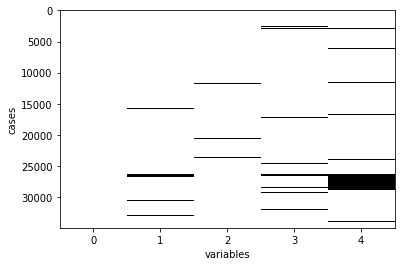

In [4]:
def scan_for_missing_structure(df):
    rec = {}
    for col in df.columns:
        if 'Lag1' in col or 'date_time' in col: continue
        rec[col] = [0, []] # missing tally, and record
    for index, row in df.iterrows():
        for col, info in rec.items():
            if np.isnan(row[col]): # incriment missing tally
                info[0] += 1
            elif not np.isnan(row[col]) and info[0] > 0:
                info[1].append(info[0])
                info[0] = 0
    #for k, v in rec.items():
    #    print(k, v)
    return rec

# Not used
def group_results(groupings, results):
    cats = {}
    for g in groupings:
        cats[g] = 0
    res = {}
    for col, info in results.items():
        res[col] = copy.deepcopy(cats)
        for v in info[1]:
            if v == 1: res[col]['1'] += 1
            elif v <= 5: res[col]['2-5'] += 1
            elif v <= 23: res[col]['5-23'] += 1
            elif v <= 168: res[col]['24-168'] += 1
            elif v <= 1000: res[col]['169-1000'] += 1
            elif v <= 2000: res[col]['1001-2000'] += 1
            elif v <= 3000: res[col]['2001-3000'] += 1
            else: res[col]['3001+'] += 1
    for k, v in res.items():
        print(k, v)
    return res


def remove_locations(df, requested_gaps, cnt=-1):
    # Begin with the longest requested gaps and work you way
    # to smaller requested gaps
    for col, info in requested_gaps.items():
        info[1].sort()
        info[1].reverse()
        #print(col, info[1])
        for length in info[1]:
            # Try in requested column first the simple way, if that doesn't
            # work, try the "difficult" way where some existing
            # np.nans will be included in naned data
            if find_and_remove_location(df, col, length):
                find_and_remove_difficult_location(df, col, length, cnt)



# Loop over vals in the dataframe and find a continous region which
# has a reasonably "good" data buffer around the requested length of data to remove.
# Change the valse to np.nan
def find_and_remove_location(df, col, length, verbose=False):
    # Start at a random index position to not bias the removals
    # all towards the front
    max_good_data = 0
    loc = int(np.random.uniform(0, len(df.index)))
    if loc == len(df.index):
        loc -= 1
    start_of_good_data = loc
    length_of_good_data = 0
    n_loops = 0
    # How much good data on each side of the new gap?
    if length <= 100:
        tgt_length = 5 * length 
        buffer = 2 * length # 2x on each side
    elif length <= 1000:
        tgt_length = 3 * length 
        buffer = 1 * length # 1x on each side
    else:
        tgt_length = int(1.5 * length) 
        buffer = int(0.25 * length) # 0.25x on each side
    while True:
        if np.isnan(df.at[loc, col]):
            start_of_good_data = loc + 1 # This is the following value
            # and will continuously incriment if isnan()
            length_of_good_data = 0
        else: # good data
            length_of_good_data += 1
            if length_of_good_data > max_good_data:
                max_good_data = length_of_good_data

        # Remember pandas DataFrame has different slice notation that normal python
        # where the terminal value is included in the slice
        if length_of_good_data == tgt_length - 1:
            if verbose:
                print("Found a great spot for removal, col {:}, l={:d}, tgt_l={:d}, buffer={:d}, [{:d}:{:d}]".format(
                        col, length, tgt_length, buffer, start_of_good_data, start_of_good_data+length_of_good_data))
            strt = start_of_good_data + buffer # Begin nan after good data buffer 
            end = start_of_good_data + buffer + length - 1
            if verbose:
                print(df.loc[start_of_good_data:start_of_good_data+length_of_good_data, col])
            df.loc[strt:end, col] = np.nan
            if verbose:
                print(df.loc[start_of_good_data:start_of_good_data+length_of_good_data, col])
            return 0
        loc += 1
        
        # Wrap to start of df
        if loc >= len(df.index):
            loc = 0
            n_loops += 1
            if n_loops > 1:
                print("Too many loops for col {} and requested length {}, max good data length {}".format(
                    col, length, max_good_data))
                return 1

            
def find_and_remove_difficult_location(df, col, length, to_take=-1, verbose=False):
    # Scan data and look for highest purity "good" data region
    # to apply np.nan
    rec = []
    print("find_and_remove_difficult_location")
    print(" - Looking for col {} for length {}".format(col, length))
    for i in range(0, int(len(df.index) - 1.5 * length)):
        rec.append((i, df.loc[i:int(i+1.5*length), col].isna().sum()))
    nan_min = 9999
    best_idx = -1
    for val in rec:
        if val[1] < nan_min:
            nan_min = val[1]
            best_idx = val[0]

    # Find other comparable locations for adding a gap.
    # Search for reginons with 20% more less NANs
    # with respect to length requested.
    others = []
    for val in rec:
        if val[1] <= length * 0.2 and abs(val[0]-best_idx) > length:
            new_gap = True
            for other in others:
                if abs(val[0]-other[0]) < length:
                    new_gap = False
            if new_gap and val[0] - length < len(df.index):
                others.append(val)
    print(" - others:")
    print(others)
    
    
    print(" - Best idx {} for nan count of {}".format(best_idx, nan_min))
    if to_take >= 0:
        print(others[to_take][0])
        print(" - Will select location based on 'Others' {} {}".format(to_take, others[to_take]))
        df.loc[int(others[to_take][0]+0.25*length):int(others[to_take][0]+1.25*length), col] = np.nan
        print(" - Difficult NAN insertion resulting in 'other' location {} with {} total np.nans".format(
            others[to_take][0],
            df.loc[others[to_take][0]:int(others[to_take][0]+1.5*length), col].isna().sum()))
    else:
        df.loc[int(best_idx+0.25*length):int(best_idx+1.25*length), col] = np.nan
        print(" - Difficult NAN insertion resulting in defaul location {} with {} total np.nans".format(
            best_idx,
            df.loc[best_idx:int(best_idx+1.5*length), col].isna().sum()))
            

np.random.seed(1)
results = scan_for_missing_structure(df)
#groupings = ['1', '2-5', '5-23',  '24-168', '169-1000', '1001-2000',
#            '2001-3000', '3001+']
plt.imshow(~df.isna(), aspect='auto')
plt.xlabel("variables")
plt.ylabel("cases")
plt.gray()
plt.show()

make_overimpute = False
if make_overimpute:
    for i in range(-1, 9): # Length of 'others' in difficult replace code for 4 CA regions
        df2 = copy.deepcopy(df)
        results2 = copy.deepcopy(results)
        remove_locations(df2, results2, i)
        plt.imshow(~df2.isna(), aspect='auto')
        plt.xlabel("variables")
        plt.ylabel("cases")
        plt.gray()
        plt.show()
        print("Saving as 'ca_for_overimpute3_{}.csv'".format(str(i).replace('-1','default')))
        df2.to_csv('ca_for_overimpute3_{}.csv'.format(str(i).replace('-1','default')), index=False, na_rep='NA')